#  MNIST Digit Classifier — Built From Scratch Using NumPy  
A simple Multilayer Perceptron implemented manually (Forward + Backprop + Adam)

This notebook demonstrates:

- Loading MNIST from custom CSV  
- Implementing activation functions  
- Implementing Cross-Entropy Loss  
- Building an MLP from scratch  
- Training with Adam optimizer  
- Evaluating and visualizing the results  

---


In [ ]:
import numpy as np


def to_one_hot(y, num_classes=10):
    y = y.astype(int)
    one_hot = np.zeros((y.shape[0], num_classes), dtype=np.float32)
    one_hot[np.arange(y.shape[0]), y] = 1.0
    return one_hot


def load_mnist_csv(path, test_ratio=0.2, shuffle=True):

    # genfromtxt با filling_values باعث می‌شود سلول‌های خالی → 0 بشوند
    data = np.genfromtxt(
        path,
        delimiter=",",
        skip_header=1,   # اگر header نداری، این را بکن 0
        filling_values=0 # خالی‌ها را با 0 پر کن
    )

    # اگر فایل خیلی بزرگ باشد، بد نیست این را چک کنیم:
    print("Raw data shape:", data.shape)

    # ستون 0 → دور ریخته می‌شود
    labels = data[:, 1]          # ستون لیبل
    pixels = data[:, 2:]         # پیکسل‌ها

    # نرمال‌سازی 0..255 → 0..1
    pixels = pixels.astype(np.float32) / 255.0

    # شافل
    N = pixels.shape[0]
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)

    test_size = int(N * test_ratio)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    X_train = pixels[train_indices]
    y_train = labels[train_indices]
    X_test = pixels[test_indices]
    y_test = labels[test_indices]

    # تبدیل به one-hot
    y_train_oh = to_one_hot(y_train, num_classes=10)
    y_test_oh = to_one_hot(y_test, num_classes=10)

    return (X_train, y_train_oh), (X_test, y_test_oh)


##  1. Load and Prepare Dataset

We load MNIST from the custom CSV file.  
The CSV format is:

- Column 0 → *estimated label* (empty)  
- Column 1 → true label (0–9)  
- Columns 2.. → pixel values (0–255)  

We normalize pixel values to `[0,1]` and convert labels to one-hot vectors.


In [2]:
(X_train, y_train_oh), (X_test, y_test_oh) = load_mnist_csv(path="mnist.csv")

print("Train shape:", X_train.shape, y_train_oh.shape)
print("Test shape:", X_test.shape, y_test_oh.shape)


Raw data shape: (42000, 786)
Train shape: (33600, 784) (33600, 10)
Test shape: (8400, 784) (8400, 10)


##  2. Activation Functions & Loss

We implement:

- **ReLU** and its derivative  
- **Softmax**
- **Cross Entropy Loss**
- **Accuracy metric**


In [3]:
# Activation Functions

def relu(z):
    return np.maximum(0, z)

def relu_deriv(z):
    return (z > 0).astype(np.float32)


def softmax(z):
    z_shift = z - np.max(z, axis=1, keepdims=True)  
    exp_z = np.exp(z_shift)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)



def cross_entropy_loss(y_pred, y_true):
    eps = 1e-9  
    y_pred_clipped = np.clip(y_pred, eps, 1 - eps)
    loss = -np.sum(y_true * np.log(y_pred_clipped)) / y_true.shape[0]
    return loss



def accuracy(y_pred, y_true):
    if y_true.ndim == 2:
        y_true_labels = np.argmax(y_true, axis=1)
    else:
        y_true_labels = y_true

    y_pred_labels = np.argmax(y_pred, axis=1)
    return np.mean(y_pred_labels == y_true_labels)


##  3. Implementing the MLP (Multilayer Perceptron)

Our MLP architecture:

- Input layer: 784 neurons  
- Hidden Layer 1: 128 neurons (ReLU)  
- Hidden Layer 2: 64 neurons  (ReLU)  
- Output layer: 10 neurons (Softmax)

We implement:
- Forward pass  
- Backpropagation  
- Adam update  
- Step method (one training iteration)


In [6]:
class MLP:
    def __init__(self, input_dim, hidden_dims=(128, 64), output_dim=10,
                 learning_rate=1e-3, beta1=0.9, beta2=0.999, eps=1e-8):
        """
        ساخت MLP با ساختار:
        input_dim → hidden_dims → output_dim
        """

        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        # برای Adam: شمارش step ها
        self.t = 0  

        # ساخت لیست لایه‌ها
        layer_dims = [input_dim] + list(hidden_dims) + [output_dim]

        # وزن‌ها و بایاس‌ها
        self.W = []
        self.b = []
        for i in range(len(layer_dims) - 1):
            in_dim = layer_dims[i]
            out_dim = layer_dims[i + 1]

            # initialization ساده
            W_i = 0.01 * np.random.randn(in_dim, out_dim).astype(np.float32)
            b_i = np.zeros((1, out_dim), dtype=np.float32)

            self.W.append(W_i)
            self.b.append(b_i)

        # Adam moments (m و v)
        self.mW = [np.zeros_like(W) for W in self.W]
        self.vW = [np.zeros_like(W) for W in self.W]
        self.mb = [np.zeros_like(b) for b in self.b]
        self.vb = [np.zeros_like(b) for b in self.b]

    # -----------------------------------------------------
    # forward pass
    # -----------------------------------------------------
    def forward(self, x):
        a = x
        zs = []           # z های هر لایه
        activations = [x] # a های هر لایه

        # لایه‌های مخفی (ReLU)
        for i in range(len(self.W) - 1):
            z = a @ self.W[i] + self.b[i]
            a = relu(z)

            zs.append(z)
            activations.append(a)

        # لایه خروجی (logits)
        z_out = activations[-1] @ self.W[-1] + self.b[-1]
        zs.append(z_out)
        activations.append(z_out)

        return z_out, zs, activations

    # -----------------------------------------------------
    # backward pass
    # -----------------------------------------------------
    def backward(self, y_pred, y_true, zs, activations):
        N = y_true.shape[0]

        # لیست گرادیان‌ها
        dW = [np.zeros_like(W) for W in self.W]
        db = [np.zeros_like(b) for b in self.b]

        # گرادیان لایه خروجی (softmax + cross entropy)
        dz = (y_pred - y_true) / N
        
        # آخرین لایه
        dW[-1] = activations[-2].T @ dz
        db[-1] = np.sum(dz, axis=0, keepdims=True)

        # لایه‌های مخفی
        for i in reversed(range(len(self.W) - 1)):
            da = dz @ self.W[i + 1].T
            dz = da * relu_deriv(zs[i])

            dW[i] = activations[i].T @ dz
            db[i] = np.sum(dz, axis=0, keepdims=True)

        return dW, db

    # -----------------------------------------------------
    # Adam update
    # -----------------------------------------------------
    def adam_update(self, dW, db):
        self.t += 1

        for i in range(len(self.W)):

            # m_t و v_t برای وزن‌ها
            self.mW[i] = self.beta1 * self.mW[i] + (1 - self.beta1) * dW[i]
            self.vW[i] = self.beta2 * self.vW[i] + (1 - self.beta2) * (dW[i] ** 2)

            # bias correction
            mW_hat = self.mW[i] / (1 - self.beta1 ** self.t)
            vW_hat = self.vW[i] / (1 - self.beta2 ** self.t)

            # update rule
            self.W[i] -= self.learning_rate * mW_hat / (np.sqrt(vW_hat) + self.eps)

            # m_t و v_t برای بایاس‌ها
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)

            mb_hat = self.mb[i] / (1 - self.beta1 ** self.t)
            vb_hat = self.vb[i] / (1 - self.beta2 ** self.t)

            self.b[i] -= self.learning_rate * mb_hat / (np.sqrt(vb_hat) + self.eps)

    # -----------------------------------------------------
    # یک قدم آموزش کامل
    # -----------------------------------------------------
    def step(self, x, y_true):
        logits, zs, activations = self.forward(x)
        y_pred = softmax(logits)

        loss = cross_entropy_loss(y_pred, y_true)

        dW, db = self.backward(y_pred, y_true, zs, activations)
        self.adam_update(dW, db)

        return loss, y_pred

    # -----------------------------------------------------
    # پیش‌بینی (class)
    # -----------------------------------------------------
    def predict(self, x):
        logits, _, _ = self.forward(x)
        y_pred = softmax(logits)
        return np.argmax(y_pred, axis=1)


In [7]:

class MLP_BN:
    def __init__(self, input_dim, hidden_dims=(128, 64), output_dim=10,
                 learning_rate=1e-3, beta1=0.9, beta2=0.999, eps=1e-8,
                 bn_momentum=0.9, bn_eps=1e-5):
        """
        MLP با Batch Normalization روی لایه‌های مخفی.

        معماری:
        input_dim -> hidden_dims[0] -> hidden_dims[1] -> ... -> output_dim

        - بعد از هر لایه مخفی:
            z = XW + b
            BN(z) -> ReLU
        - لایه خروجی: فقط linear + softmax (بدون BN)
        """

        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        self.bn_momentum = bn_momentum
        self.bn_eps = bn_eps

        self.t = 0  # برای Adam

        layer_dims = [input_dim] + list(hidden_dims) + [output_dim]
        self.num_layers = len(layer_dims) - 1
        self.num_hidden = len(hidden_dims)

        # وزن‌ها و بایاس‌ها
        self.W = []
        self.b = []
        for i in range(self.num_layers):
            in_dim = layer_dims[i]
            out_dim = layer_dims[i + 1]
            W_i = 0.01 * np.random.randn(in_dim, out_dim).astype(np.float32)
            b_i = np.zeros((1, out_dim), dtype=np.float32)
            self.W.append(W_i)
            self.b.append(b_i)

        # پارامترهای BatchNorm فقط برای لایه‌های مخفی
        self.gamma = []
        self.beta_bn = []
        self.running_mean = []
        self.running_var = []
        for i in range(self.num_hidden):
            out_dim = layer_dims[i + 1]
            self.gamma.append(np.ones((1, out_dim), dtype=np.float32))
            self.beta_bn.append(np.zeros((1, out_dim), dtype=np.float32))
            self.running_mean.append(np.zeros((1, out_dim), dtype=np.float32))
            self.running_var.append(np.ones((1, out_dim), dtype=np.float32))

        # Adam moments برای W و b
        self.mW = [np.zeros_like(W) for W in self.W]
        self.vW = [np.zeros_like(W) for W in self.W]
        self.mb = [np.zeros_like(b) for b in self.b]
        self.vb = [np.zeros_like(b) for b in self.b]

        # Adam moments برای gamma و beta_bn
        self.mGamma = [np.zeros_like(g) for g in self.gamma]
        self.vGamma = [np.zeros_like(g) for g in self.gamma]
        self.mBetaBN = [np.zeros_like(bn) for bn in self.beta_bn]
        self.vBetaBN = [np.zeros_like(bn) for bn in self.beta_bn]

    # --------------------- BatchNorm forward ---------------------
    def _batchnorm_forward(self, z, layer_idx, training):
        """
        z: (N, D)
        layer_idx: index لایهٔ مخفی
        training: اگر False باشد از running stats استفاده می‌کنیم
        """
        if training:
            mu = np.mean(z, axis=0, keepdims=True)
            var = np.var(z, axis=0, keepdims=True)

            z_norm = (z - mu) / np.sqrt(var + self.bn_eps)
            z_hat = self.gamma[layer_idx] * z_norm + self.beta_bn[layer_idx]

            # آپدیت running stats
            self.running_mean[layer_idx] = (
                self.bn_momentum * self.running_mean[layer_idx]
                + (1 - self.bn_momentum) * mu
            )
            self.running_var[layer_idx] = (
                self.bn_momentum * self.running_var[layer_idx]
                + (1 - self.bn_momentum) * var
            )

            cache = (z, z_norm, mu, var, self.gamma[layer_idx])
        else:
            mu = self.running_mean[layer_idx]
            var = self.running_var[layer_idx]
            z_norm = (z - mu) / np.sqrt(var + self.bn_eps)
            z_hat = self.gamma[layer_idx] * z_norm + self.beta_bn[layer_idx]
            cache = None  # در حالت eval به backprop نیاز نداریم

        return z_hat, z_norm, cache

    # --------------------- forward ---------------------
    def forward(self, x, training=True):
        """
        x: (N, D)
        خروجی:
            logits,
            activations: لیست a_0, a_1, ..., a_L
            pre_relu: خروجی BN قبل از ReLU برای هر لایه مخفی
            bn_caches: اطلاعات لازم برای backprop BN
        """
        a = x
        activations = [x]

        pre_relu = []     # خروجی BN قبل از ReLU
        bn_caches = []    # per hidden layer

        # لایه‌های مخفی: Linear -> BN -> ReLU
        for i in range(self.num_hidden):
            z = a @ self.W[i] + self.b[i]         # (N, hidden_dim_i)
            z_hat, z_norm, cache = self._batchnorm_forward(z, i, training)
            a = relu(z_hat)

            pre_relu.append(z_hat)
            bn_caches.append((z, z_norm, cache))  # cache شامل mu, var, gamma است
            activations.append(a)

        # لایه خروجی: فقط Linear
        logits = activations[-1] @ self.W[-1] + self.b[-1]
        activations.append(logits)

        return logits, activations, pre_relu, bn_caches

    # --------------------- backward ---------------------
    def backward(self, y_pred, y_true, activations, pre_relu, bn_caches):
        N = y_true.shape[0]

        dW = [np.zeros_like(W) for W in self.W]
        db = [np.zeros_like(b) for b in self.b]
        dGamma = [np.zeros_like(g) for g in self.gamma]
        dBetaBN = [np.zeros_like(bn) for bn in self.beta_bn]

        # --- گرادیان لایه خروجی (softmax + cross entropy) ---
        dz = (y_pred - y_true) / N
        dW[-1] = activations[-2].T @ dz
        db[-1] = np.sum(dz, axis=0, keepdims=True)

        # --- backprop از لایه‌های مخفی به عقب ---
        for i in reversed(range(self.num_hidden)):
            # گرادیان نسبت به activations لایه i+1 (بعد ReLU)
            da = dz @ self.W[i + 1].T

            # ReLU backprop
            dz_hat = da * relu_deriv(pre_relu[i])   # pre_relu[i] = z_hat قبل ReLU

            # BatchNorm backprop
            z, z_norm, cache = bn_caches[i]
            if cache is None:
                # در eval استفاده نمی‌شود، فقط training
                raise RuntimeError("BN cache is None in training backward pass")

            z_raw, z_norm_val, mu, var, gamma_i = cache
            # (توجه: z_raw == z و z_norm_val == z_norm)

            # dBeta, dGamma
            dBetaBN[i] = np.sum(dz_hat, axis=0, keepdims=True)
            dGamma[i] = np.sum(dz_hat * z_norm_val, axis=0, keepdims=True)

            # گرادیان نسبت به z_norm
            dz_norm = dz_hat * gamma_i

            # فرمول فشرده‌ی BN backward
            # منبع: پیاده‌سازی استاندارد:
            # dz = (1/N) * 1/sqrt(var+eps) * (N*dz_norm - sum(dz_norm) - z_norm*sum(dz_norm*z_norm))
            N_batch = z.shape[0]
            var_eps = var + self.bn_eps
            std_inv = 1.0 / np.sqrt(var_eps)

            dz = (1.0 / N_batch) * std_inv * (
                N_batch * dz_norm
                - np.sum(dz_norm, axis=0, keepdims=True)
                - z_norm_val * np.sum(dz_norm * z_norm_val, axis=0, keepdims=True)
            )

            # حالا dz نسبت به خروجی Linear قبلی است:
            dW[i] = activations[i].T @ dz
            db[i] = np.sum(dz, axis=0, keepdims=True)

        return dW, db, dGamma, dBetaBN

    # --------------------- Adam update ---------------------
    def adam_update(self, dW, db, dGamma, dBetaBN):
        self.t += 1

        # آپدیت W و b
        for i in range(self.num_layers):
            # وزن‌ها
            self.mW[i] = self.beta1 * self.mW[i] + (1 - self.beta1) * dW[i]
            self.vW[i] = self.beta2 * self.vW[i] + (1 - self.beta2) * (dW[i] ** 2)

            mW_hat = self.mW[i] / (1 - self.beta1 ** self.t)
            vW_hat = self.vW[i] / (1 - self.beta2 ** self.t)

            self.W[i] -= self.learning_rate * mW_hat / (np.sqrt(vW_hat) + self.eps)

            # بایاس‌ها
            self.mb[i] = self.beta1 * self.mb[i] + (1 - self.beta1) * db[i]
            self.vb[i] = self.beta2 * self.vb[i] + (1 - self.beta2) * (db[i] ** 2)

            mb_hat = self.mb[i] / (1 - self.beta1 ** self.t)
            vb_hat = self.vb[i] / (1 - self.beta2 ** self.t)

            self.b[i] -= self.learning_rate * mb_hat / (np.sqrt(vb_hat) + self.eps)

        # آپدیت gamma و beta_bn (فقط hidden layers)
        for i in range(self.num_hidden):
            self.mGamma[i] = self.beta1 * self.mGamma[i] + (1 - self.beta1) * dGamma[i]
            self.vGamma[i] = self.beta2 * self.vGamma[i] + (1 - self.beta2) * (dGamma[i] ** 2)

            mGamma_hat = self.mGamma[i] / (1 - self.beta1 ** self.t)
            vGamma_hat = self.vGamma[i] / (1 - self.beta2 ** self.t)

            self.gamma[i] -= self.learning_rate * mGamma_hat / (np.sqrt(vGamma_hat) + self.eps)

            self.mBetaBN[i] = self.beta1 * self.mBetaBN[i] + (1 - self.beta1) * dBetaBN[i]
            self.vBetaBN[i] = self.beta2 * self.vBetaBN[i] + (1 - self.beta2) * (dBetaBN[i] ** 2)

            mBeta_hat = self.mBetaBN[i] / (1 - self.beta1 ** self.t)
            vBeta_hat = self.vBetaBN[i] / (1 - self.beta2 ** self.t)

            self.beta_bn[i] -= self.learning_rate * mBeta_hat / (np.sqrt(vBeta_hat) + self.eps)

    # --------------------- یک قدم آموزش ---------------------
    def step(self, x, y_true):
        logits, activations, pre_relu, bn_caches = self.forward(x, training=True)
        y_pred = softmax(logits)
        loss = cross_entropy_loss(y_pred, y_true)

        dW, db, dGamma, dBetaBN = self.backward(y_pred, y_true, activations, pre_relu, bn_caches)
        self.adam_update(dW, db, dGamma, dBetaBN)

        return loss, y_pred

    # --------------------- پیش‌بینی ---------------------
    def predict(self, x):
        logits, _, _, _ = self.forward(x, training=False)
        y_pred = softmax(logits)
        return np.argmax(y_pred, axis=1)


##  4. Training the Model

We train the model using mini-batch gradient descent  
with **Adam optimizer**.

Hyperparameters:

- Epochs: 10  
- Batch Size: 64  
- Learning Rate: 1e-3  


In [8]:
# ------------------------
# 1) ساخت مدل
# ------------------------
input_dim = X_train.shape[1]   # باید 784 باشه تو دیتای تو
model = MLP(
    input_dim=input_dim,
    hidden_dims=(128, 64),     # می‌تونی بعداً عوضش کنی
    output_dim=10,
    learning_rate=1e-3
)

# ------------------------
# 2) هایپرپارامترها
# ------------------------
num_epochs = 10
batch_size = 64

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

N = X_train.shape[0]

for epoch in range(num_epochs):
    # شافل کردن داده‌ها در هر epoch
    indices = np.arange(N)
    np.random.shuffle(indices)
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train_oh[indices]

    epoch_loss = 0.0
    epoch_correct = 0
    epoch_samples = 0

    # ------------------------
    # 3) mini-batch training
    # ------------------------
    for start in range(0, N, batch_size):
        end = start + batch_size
        x_batch = X_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]

        if x_batch.shape[0] == 0:
            continue

        # یک قدم آموزش: forward + backward + Adam update
        loss, y_pred = model.step(x_batch, y_batch)

        # جمع کردن برای میانگین loss و accuracy
        batch_size_actual = x_batch.shape[0]
        epoch_loss += loss * batch_size_actual

        preds_labels = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_batch, axis=1)
        epoch_correct += np.sum(preds_labels == true_labels)

        epoch_samples += batch_size_actual

    # میانگین loss و accuracy روی train
    epoch_loss /= epoch_samples
    epoch_acc = epoch_correct / epoch_samples

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # ------------------------
    # 4) ارزیابی روی test set
    # ------------------------
    logits_test, _, _ = model.forward(X_test)
    y_test_pred = softmax(logits_test)

    test_loss = cross_entropy_loss(y_test_pred, y_test_oh)
    test_acc = accuracy(y_test_pred, y_test_oh)

    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"- Train loss: {epoch_loss:.4f}, Train acc: {epoch_acc:.4f} "
          f"- Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")


Epoch 1/10 - Train loss: 0.6674, Train acc: 0.7866 - Test loss: 0.3819, Test acc: 0.8881
Epoch 2/10 - Train loss: 0.2991, Train acc: 0.9121 - Test loss: 0.2602, Test acc: 0.9252
Epoch 3/10 - Train loss: 0.2039, Train acc: 0.9406 - Test loss: 0.1977, Test acc: 0.9427
Epoch 4/10 - Train loss: 0.1554, Train acc: 0.9534 - Test loss: 0.1743, Test acc: 0.9495
Epoch 5/10 - Train loss: 0.1236, Train acc: 0.9637 - Test loss: 0.1452, Test acc: 0.9580
Epoch 6/10 - Train loss: 0.1002, Train acc: 0.9711 - Test loss: 0.1290, Test acc: 0.9626
Epoch 7/10 - Train loss: 0.0808, Train acc: 0.9755 - Test loss: 0.1276, Test acc: 0.9613
Epoch 8/10 - Train loss: 0.0678, Train acc: 0.9794 - Test loss: 0.1154, Test acc: 0.9670
Epoch 9/10 - Train loss: 0.0556, Train acc: 0.9826 - Test loss: 0.1113, Test acc: 0.9688
Epoch 10/10 - Train loss: 0.0472, Train acc: 0.9855 - Test loss: 0.1315, Test acc: 0.9643


In [9]:
input_dim = X_train.shape[1]

model_bn = MLP_BN(
    input_dim=input_dim,
    hidden_dims=(128, 64),
    output_dim=10,
    learning_rate=1e-3
)

num_epochs_bn = 10
batch_size = 64

train_losses_bn = []
train_accuracies_bn = []
test_losses_bn = []
test_accuracies_bn = []

N = X_train.shape[0]

for epoch in range(num_epochs_bn):
    indices = np.arange(N)
    np.random.shuffle(indices)
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train_oh[indices]

    epoch_loss = 0.0
    epoch_correct = 0
    epoch_samples = 0

    for start in range(0, N, batch_size):
        end = start + batch_size
        x_batch = X_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]

        if x_batch.shape[0] == 0:
            continue

        loss, y_pred = model_bn.step(x_batch, y_batch)

        bs = x_batch.shape[0]
        epoch_loss += loss * bs

        preds_labels = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_batch, axis=1)
        epoch_correct += np.sum(preds_labels == true_labels)

        epoch_samples += bs

    epoch_loss /= epoch_samples
    epoch_acc = epoch_correct / epoch_samples

    train_losses_bn.append(epoch_loss)
    train_accuracies_bn.append(epoch_acc)

    # eval روی test set با mode = eval (training=False)
    logits_test_bn, _, _, _ = model_bn.forward(X_test, training=False)
    y_test_pred_bn = softmax(logits_test_bn)

    test_loss_bn = cross_entropy_loss(y_test_pred_bn, y_test_oh)
    test_acc_bn = accuracy(y_test_pred_bn, y_test_oh)

    test_losses_bn.append(test_loss_bn)
    test_accuracies_bn.append(test_acc_bn)

    print(f"[BN] Epoch {epoch+1}/{num_epochs_bn} "
          f"- Train loss: {epoch_loss:.4f}, Train acc: {epoch_acc:.4f} "
          f"- Test loss: {test_loss_bn:.4f}, Test acc: {test_acc_bn:.4f}")


[BN] Epoch 1/10 - Train loss: 0.4173, Train acc: 0.9219 - Test loss: 0.1382, Test acc: 0.9588
[BN] Epoch 2/10 - Train loss: 0.1137, Train acc: 0.9667 - Test loss: 0.1031, Test acc: 0.9683
[BN] Epoch 3/10 - Train loss: 0.0774, Train acc: 0.9764 - Test loss: 0.0885, Test acc: 0.9721
[BN] Epoch 4/10 - Train loss: 0.0602, Train acc: 0.9810 - Test loss: 0.0911, Test acc: 0.9706
[BN] Epoch 5/10 - Train loss: 0.0468, Train acc: 0.9858 - Test loss: 0.0877, Test acc: 0.9721
[BN] Epoch 6/10 - Train loss: 0.0383, Train acc: 0.9876 - Test loss: 0.0953, Test acc: 0.9713
[BN] Epoch 7/10 - Train loss: 0.0336, Train acc: 0.9887 - Test loss: 0.0850, Test acc: 0.9749
[BN] Epoch 8/10 - Train loss: 0.0295, Train acc: 0.9910 - Test loss: 0.0808, Test acc: 0.9767
[BN] Epoch 9/10 - Train loss: 0.0221, Train acc: 0.9931 - Test loss: 0.0926, Test acc: 0.9731
[BN] Epoch 10/10 - Train loss: 0.0244, Train acc: 0.9916 - Test loss: 0.0840, Test acc: 0.9749


## 📈 6. Training Curves

Plot training & test loss  
and training & test accuracy.


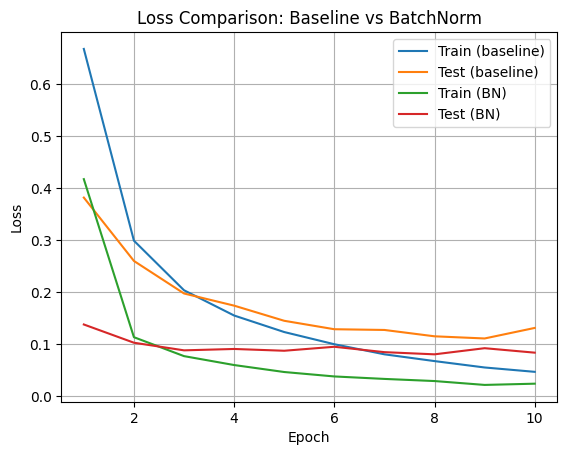

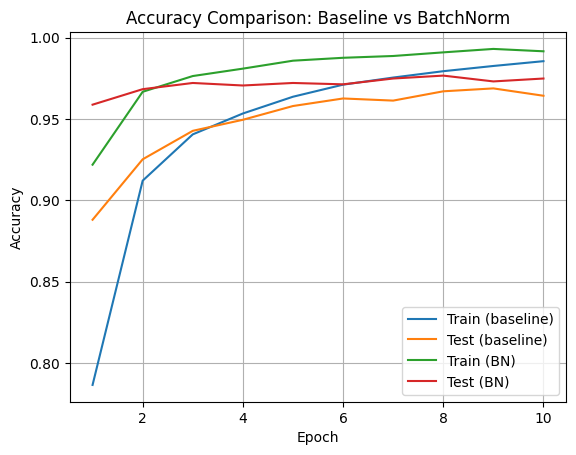

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs_bn + 1)

# -------- Loss Comparison --------
plt.figure()
plt.plot(epochs, train_losses, label="Train (baseline)")
plt.plot(epochs, test_losses, label="Test (baseline)")
plt.plot(epochs, train_losses_bn, label="Train (BN)")
plt.plot(epochs, test_losses_bn, label="Test (BN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Comparison: Baseline vs BatchNorm")
plt.legend()
plt.grid(True)
plt.show()

# -------- Accuracy Comparison --------
plt.figure()
plt.plot(epochs, train_accuracies, label="Train (baseline)")
plt.plot(epochs, test_accuracies, label="Test (baseline)")
plt.plot(epochs, train_accuracies_bn, label="Train (BN)")
plt.plot(epochs, test_accuracies_bn, label="Test (BN)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Baseline vs BatchNorm")
plt.legend()
plt.grid(True)
plt.show()
